### General Imports

In [531]:
# Numerical analysis
import datetime
import geopy.distance
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr

# Visualization
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.pyplot as plt

# Remote access
from bs4 import BeautifulSoup
import requests

# Miscellaneous
import os
import warnings
warnings.filterwarnings("ignore")

### Large-scale analysis

#### Data reading methods
This section contains functions relevant to reading different data formats.

##### HURDAT2

In [532]:
def read_hurdat(year_range=None):
    
    ''' Access HURDAT data. '''
    # Path for HURDAT data
    url = 'https://www.aoml.noaa.gov/hrd/hurdat/hurdat2.html'
    # Define raw HURDAT column headers
    col_headers = ['date', 'hour', 'identifier', 'status', 'lat', 'lon', 'max_wnd', 'min_p', 
                   '34_kt_ne', '34_kt_se', '34_kt_sw', '34_kt_nw', '50_kt_ne', '50_kt_se', '50_kt_sw', '50_kt_nw',
                   '64_kt_ne', '64_kt_se', '64_kt_sw', '64_kt_nw', 'rmw']
    # Open data. Note that missing data is denoted with the value -999.
    raw = pd.read_csv(url, sep=',', skiprows=3, names=col_headers, error_bad_lines=False)
    
    ''' Pull storm-specific header lines. '''
    # Initialize list to hold named data
    data, atcf_name = [], None 
    # Iterate over each entry to separate storm heading rows from data rows
    for index, row in raw.iterrows():
        # If AL in the name, pull the identifier name
        if 'AL' in row['date']:
            atcf_name = row['date']
        # Else, assign the retrieved name to the storm
        else:
            row['name'] = atcf_name
            data.append(row)
    # Concatenate the Dataframe
    data = pd.DataFrame(data)
    # Convert coordinate columns to floats
    data['lat'] = data['lat'].str[0:-1].astype(float)
    data['lon'] = -data['lon'].str[0:-1].astype(float)
    
    ''' Other filtering. '''
    # Filter out missing data and last 3 entries, which are residual HTML from the URL request.
    data = data.where(data != -999)[:-3]
    # Filter out entries with bad dates.
    data = data.where(~data['date'].str.contains('pre')).dropna(how='all')
    # Reformat dates
    data['datetime'] = pd.to_datetime(data['date'] + data['hour'], format='%Y%m%d %H%M')
    data['date'] = pd.to_datetime(data['date'])
    # Drop erroneous spaces
    data['status'] = data['status'].str.replace(' ', '')
    # Assign SSHWS category
    data['category'] = np.nan
    data['status'].loc[(data['max_wnd'] >= 64) & (data['max_wnd'] < 83)] = 'HU_1'
    data['status'].loc[(data['max_wnd'] >= 83) & (data['max_wnd'] < 96)] = 'HU_2'
    data['status'].loc[(data['max_wnd'] >= 96) & (data['max_wnd'] < 113)] = 'HU_3'
    data['status'].loc[(data['max_wnd'] >= 113) & (data['max_wnd'] < 137)] = 'HU_4'
    data['status'].loc[(data['max_wnd'] >= 137)] = 'HU_5'
    categories = {'DB': 0, 'WV': 0, 'LO': 0, 'TD': 1, 'EX': 2, 'SD': 1, 'SS': 2, 
                  'TS': 2, 'HU': 3, 'HU_1': 3, 'HU_2': 4, 'HU_3': 5, 'HU_4': 6, 'HU_5': 7}
    category_list = [categories[s] if s != 'nan' else np.nan for s in list(data['status'].astype(str))]
    data['category'] = category_list
    
    # Filter by year range provided
    data = data.where((data['date'].dt.year >= min(year_range)) & (data['date'].dt.year < max(year_range))) if year_range else data
    
    return data

##### MJO RMM
Source: Australian Bureau of Meteorology, http://www.bom.gov.au/climate/mjo/

In [533]:
def read_mjo_rmm():
    # Define local path for MJO RMM data
    path = 'data/rmm.txt'
    # Read header data into list
    col_headers = list(pd.read_csv(path, sep=',', nrows=0))
    # Clean up the headers
    col_headers = [item[1:].split('.')[0] for item in col_headers]
    # Read in raw data and remove extraneous last column
    raw = pd.read_csv(path, sep='\s+', skiprows=1).iloc[:, :-1]
    # Reformat column headers
    raw.columns = col_headers
    # Offload data as a copy of raw
    data = raw.copy()
    # Generate datetime column for ease of use
    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
    # Filter outliers
    data = data.where((data != 1e36) & (data != 999)).dropna()
    
    return data

#### Copernicus ERA5 reanalysis data API request

In [534]:
def era5_download(variable, pressure_level):
    ''' Method to download ERA5 reanalysis data for a given variable and pressure level. '''
    import cdsapi

    c = cdsapi.Client()

    filename = '/Users/gabriel/Documents/ccny/spring_2022/eas_a4170/project/data/era5/{0}_{1}hpa.nc'.format(variable, pressure_level)

    c.retrieve(
        'reanalysis-era5-pressure-levels-monthly-means',
        {
            'product_type': 'monthly_averaged_reanalysis',
            'variable': str(variable),
            'pressure_level': str(pressure_level),
            'year': [
                '1979', '1980', '1981',
                '1982', '1983', '1984',
                '1985', '1986', '1987',
                '1988', '1989', '1990',
                '1991', '1992', '1993',
                '1994', '1995', '1996',
                '1997', '1998', '1999',
                '2000', '2001', '2002',
                '2003', '2004', '2005',
                '2006', '2007', '2008',
                '2009', '2010', '2011',
                '2012', '2013', '2014',
                '2015', '2016', '2017',
                '2018', '2019', '2020',
                '2021',
            ],
            'month': [
                '06', '07', '08',
                '09', '10', '11',
            ],
            'time': '00:00',
            'area': [
                50, -100, 0,
                -10,
            ],
            'format': 'netcdf',
        },
        filename)

# Define variable and level desired for download
dataset = [('divergence', 200)]
# Download the data
for item in dataset:
    era5_download(item[0], item[1])

2022-04-29 15:40:37,165 INFO Welcome to the CDS
2022-04-29 15:40:37,166 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels-monthly-means
2022-04-29 15:40:37,357 INFO Request is completed
2022-04-29 15:40:37,359 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data8/adaptor.mars.internal-1651241545.513819-18969-6-5cf3b35c-e3a3-431d-a0d9-a9a228f802a0.nc to /Users/gabriel/Documents/ccny/spring_2022/eas_a4170/project/data/era5/divergence_200hpa.nc (35.7M)


KeyboardInterrupt: 

#### Data processing methods
This section contains functions relevant to modifying data that has been read in.

##### HURDAT2 rapid intensification

In [535]:
def ri(data):
    # Initialize list to hold rows after data processing
    rows = []
    # Group by storm name to allow storm-specific analysis
    for storm, storm_data in data.groupby('name'):
        # Initialize elapsed time
        elapsed = 0
        # Initialize RI thresholds
        threshold_hour, threshold_wnd = 24.0, 30
        # Iterate over each advisory of each storm
        for index, row in storm_data.iterrows():
            # Calculate number of hours elapsed since first HURDAT instance of storm
            elapsed = (row['datetime'] - storm_data.iloc[0]['datetime']).delta / 1e9 / 3600 
            # If the storm duration has exceeded the RI temporal threshold, dig into the storm details
            if (elapsed >= threshold_hour):
                # Get the previous time to compare data to
                prev_time = row['datetime'] - datetime.timedelta(hours=threshold_hour)
                # Get the change in maximum wind speed
                d_max_wnd = row['max_wnd'] - storm_data.loc[storm_data['datetime'] == prev_time]['max_wnd']
                # If the maximum wind speed meets or exceeds the RI threshold for wind, add the RI label to this instance
                if d_max_wnd.values >= threshold_wnd:
                    row['ri'] = True
                # Else, mark as False
                else:
                    row['ri'] = False
            # Else, mark as false
            else:
                row['ri'] = False
            # Add row to list of rows
            rows.append(row)
    # Rebuild Pandas DataFrame from RI-processed data
    data = pd.DataFrame(rows)
    
    return data

##### Match modified HURDAT and MJO RMM datasets
Run the corresponding data grab functions and match the RI-modified HURDAT DataFrame with the MJO RMM DataFrame by date

In [536]:
hurdat = read_hurdat(year_range=[1980, 2022])
ri_data = ri(hurdat)
mjo_rmm = read_mjo_rmm()
dataset = ri_data.merge(mjo_rmm, on='date')
# Storms with rapid intensification events
tcs_ri = dataset.loc[dataset['name'].isin(dataset.loc[dataset['ri']]['name'].unique())].sort_values('name')

''' Grab the MJO data with the strongest amplitudes for maximum signal. '''
# Initialize list
quartiles = []
# Iterate over all phases and grab the 25% of days with the highest amplitudes (strongest MJO signal)
for group, group_data in mjo_rmm.groupby('phase'):
    # Get highest quartile of amplitude values
    temp = group_data.sort_values('amplitude', ascending=False)[:len(group_data)//4]
    quartiles.append(temp)
# Concatenate
mjo_rmm = pd.concat(quartiles)

b'Skipping line 29280: expected 21 fields, saw 22\n'


#### ERA5 reanalysis data processing and visualization

In [537]:
''' Iterate through netCDF files in the 'era5' directory. '''
# Specify directory with ERA5 data
dirname = '/Users/gabriel/Documents/ccny/spring_2022/eas_a4170/project/data/era5'
# Initialize list to hold netCDF data
era5_data = []
# Iterate through files to append to list
for file in os.listdir(dirname):
    if file.split('.')[-1] == 'nc':
        # Grab the pressure level corresponding to the current file
        pressure_level = file.split('_')[-1][0:3]
        # Create dataset
        temp = xr.open_dataset(os.path.join(dirname, file))
        # Add pressure level to the dataset
        temp = temp.assign_coords(level=('level', [float(pressure_level)]))
        # Remove history attribute to prevent compatibility errors
        temp.attrs['history'] = None
        era5_data.append(temp)
# Combine all datasets
era5_data = xr.combine_by_coords(era5_data)

''' Filter MJO data to pass into the ERA5 dataset. '''
# Group by month and round phase value to nearest integer
mjo_rmm_ = mjo_rmm.copy().set_index('date')
mjo_rmm_ = mjo_rmm_.groupby(['year', 'month']).mean()['phase'].reset_index()
# Generate new column with re-formatted date string
mjo_rmm_['time'] = pd.to_datetime(mjo_rmm_['year'].astype(str) + '-' + mjo_rmm_['month'].astype(str).str.zfill(2) + '-01')
# Filter times to match ERA5 data
times = [time for time in mjo_rmm_['time'] if time in era5_data.time.values]
mjo_rmm_ = mjo_rmm_[mjo_rmm_['time'].isin(times)].set_index('time')['phase']
# Merge datasets
era5_data = xr.merge([era5_data, mjo_rmm_.to_xarray().to_dataset()])
# Derived parameters
era5_data['vws_zonal'] = era5_data['u'].sel(level=200) - era5_data['u'].sel(level=850)

In [538]:
''' Define dictionary to group ERA5 data by MJO phase. '''
# Initialize dictionary
phases = {}
# Iterate through phases
for i in range(1, 9):
    # Define phase name string
    phase_str = 'phase_{0}'.format(i)
    # For phases 1 and 7, bound the phase definition to the upper or lower -0.5. Else, grab +/- 0.5.
    if i == 1:
        phases[phase_str] = era5_data.where((era5_data['phase'] >= i) & (era5_data['phase'] < i+0.5), drop=True)
    elif i == 8:
        phases[phase_str] = era5_data.where((era5_data['phase'] >= i-0.5) & (era5_data['phase'] < i), drop=True)
    else:
        phases[phase_str] = era5_data.where((era5_data['phase'] >= i-0.5) & (era5_data['phase'] < i+0.5), drop=True)

##### Plotting

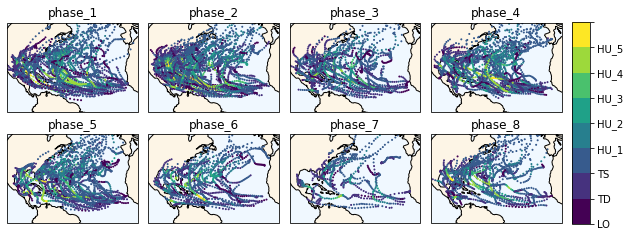

In [117]:
# Define plot extent and center
extent = [-100, -10, 0, 50]
central_lat, central_lon = np.nanmean(extent[2:]), np.nanmean(extent[0:2])

# Define projections
proj_ortho = ccrs.Orthographic(central_latitude=central_lat, central_longitude=central_lon)
proj_pc = ccrs.PlateCarree()

# Initialize plot
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(8, 4), subplot_kw={'projection': proj_ortho})

# Colormap definition
bounds = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

for i, ax in enumerate(fig.axes):
    # Plot formatting
    ax.set_extent(extent)
    ax.add_feature(cfeature.OCEAN, facecolor='aliceblue')
    ax.add_feature(cfeature.LAND, facecolor='oldlace')
    ax.coastlines()

    # Plot storm tracks
    for tc_name, tc in tcs_ri.groupby('name'):
        if tc['phase'].mode().values[0] == i+1:
            tc = tc.sort_values('date')
            im = ax.scatter(tc['lon'], tc['lat'], c=tc['category'], s=1, transform=proj_pc, norm=norm)
    
    ax.set_title('phase_{0}'.format(i+1))
    
fig.subplots_adjust(hspace=-0.4)
cax = fig.add_axes([1, 0.15, 0.03, 0.7]) 
colorbar = fig.colorbar(im, cax=cax)
colorbar.ax.set_yticklabels(['LO', 'TD', 'TS', 'HU_1', 'HU_2', 'HU_3', 'HU_4', 'HU_5', '']) 
fig.tight_layout()

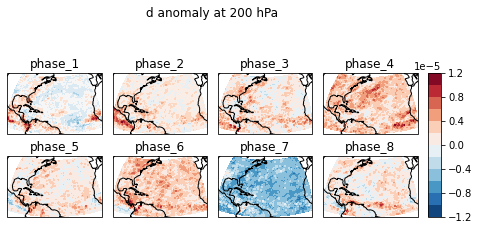

In [168]:
''' ERA5 data visualization. '''
# Define plot extent and center
extent = [-100, -10, 0, 40]
central_lat, central_lon = np.nanmean(extent[2:]), np.nanmean(extent[0:2])

# Define projections
proj_ortho = ccrs.Orthographic(central_latitude=central_lat, central_longitude=central_lon)
proj_pc = ccrs.PlateCarree()

# Initialize plot
fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, subplot_kw={'projection': proj_ortho})

# Define parameter to be evaluated
param, level = 'd', 200

for i, ax in enumerate(fig.axes):
    
    phase_num = 'phase_{0}'.format(i+1)
    
    if level:
        data = (phases[phase_num][param].mean('time') - era5_data[param].mean('time')).sel(level=level)
    else:
        data = (phases[phase_num][param].mean('time') - era5_data[param].mean('time'))
    levels = 12
    im = ax.contourf(data.longitude, data.latitude, data.values, transform=proj_pc, cmap='RdBu_r', 
                     levels=levels)
    ax.coastlines()
    ax.set_title('{0}'.format(phase_num))

fig.subplots_adjust(hspace=-0.75)
cax = fig.add_axes([1, 0.25, 0.03, 0.5]) 
fig.colorbar(im, cax=cax)
fig.tight_layout()

fig.suptitle('{0} anomaly at {1} hPa'.format(param, level));

### Small-scale analysis
This portion of the analysis deals with small-scale phenomena and analyzing their correlation with MJO phase. The data for this section will be satellite-based, whereas the analysis will be focused on phenomena related to rapid intensification, such as vortical hot towers.

#### Selection of storms within a phase for satellite imagery purposes

In [624]:
def gmi_data_download(storm_name, storm_data, date_isel=0):

    ''' Access method for Global Microwave Imager data. 
        Taken from: https://disc.gsfc.nasa.gov/data-access#python-requests.
        
        Note - url should be of format: 
        "https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L1C/GPM_1CGPMGMI_R.05/YEAR/DOY". '''

    # Define path to save files locally to
    local_dirpath = '/Users/gabriel/Documents/ccny/spring_2022/eas_a4170/project/data/gmi/{0}'.format(storm_name)
    # Create the directory if it doesn't exist
    if not os.path.isdir(local_dirpath):
        os.mkdir(local_dirpath)

    # Grab dates
    date = list(storm_data[(storm_data['name'] == storm_name) & storm_data['ri']]['date'].unique())[date_isel]
    
    # Get year and day of year (doy) for path building
    year, doy = pd.to_datetime(date).strftime('%Y'), pd.to_datetime(date).strftime('%j')
    # Define url
    url = 'https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L1C/GPM_1CGPMGMI_R.05/{0}/{1}'.format(year, doy)
    # year, doy = url.split('/')[-2], url.split('/')[-1]
    # Get page source to scrape links
    soup = BeautifulSoup(requests.get(url, verify=False).content, features='html.parser')
    # Scrape all HDF5 link from the page
    links = []
    # Iterate through all links
    for link in soup.findAll('a'):
        href = link.get('href')
        # Only pull HDF5 links
        if href.split('.')[-1] == 'HDF5':
            links.append(os.path.join(url, href))

    for link in links:
        # Define local file name
        filename = os.path.join(local_dirpath, link.split('/')[-1])
        # Check to see if file is already downloaded. If so, skip this link.
        if link.split('/')[-1] in os.listdir(local_dirpath):
            # print('File {0} already downloaded. Onto the next one...'.format(link))
            continue
        else:
            # Access the page
            print(link)
            result = requests.get(link)
            try:
                result.raise_for_status()
                f = open(filename, 'wb')
                f.write(result.content)
                f.close()
                print('contents of URL written to ' + filename)
            except:
                print('requests.get() returned an error code ' + str(result.status_code))

In [540]:
def get_rmw_extent(df):
    
    ''' Method to get spatial extent of a storm from the quadrant winds given a DataFrame. '''
    
    # Define names of columns with spatial extent of winds
    fields = ['34_kt_ne', '34_kt_se', '34_kt_sw', '34_kt_nw', '50_kt_ne',
              '50_kt_se', '50_kt_sw', '50_kt_nw', '64_kt_ne', '64_kt_se', 
              '64_kt_sw', '64_kt_nw']
    # Initialize value of the radius of maximum winds (RMW)
    rmw = 0
    # Iterate through each field and get the maximum value and convert from nautical miles to km
    rmw = np.nanmax([df[field].max()*1.852 for field in fields if df[field].max() > rmw])
    # Define the approximate Earth radius (km)
    r_earth = 6378
    # Iterate through each DataFrame row to get the extents for the storm instance
    lat_min, lat_max, lon_min, lon_max = df['lat'].mean(), df['lat'].mean(), df['lon'].mean(), df['lon'].mean()
    for _, row in df.iterrows():
        # Convert distance to coordinates and add to existing coordinate
        lat_min_ = row['lat'] - (rmw / r_earth) * (180 / np.pi);
        lat_max_ = row['lat'] + (rmw / r_earth) * (180 / np.pi)
        lon_min_ = row['lon'] - (rmw / r_earth) * (180 / np.pi) / np.cos(row['lon'] * np.pi/180);
        lon_max_ = row['lon'] + (rmw / r_earth) * (180 / np.pi) / np.cos(row['lon'] * np.pi/180);
        # Change values if the extent is pushed larger
        lat_min = lat_min_ if lat_min_ < lat_min else lat_min
        lat_max = lat_max_ if lat_max_ > lat_max else lat_max
        lon_min = lon_min_ if lon_min_ < lon_min else lon_min
        lon_max = lon_max_ if lon_max_ > lon_max else lon_max
        
    center = [np.nanmean([lat_min, lat_max]), np.nanmean([lon_min, lon_max])]
    extent = [lon_min, lon_max, lat_min, lat_max]
            
    return center, extent

In [638]:
def gmi_swath_match(storm_name, storm_data, channel=5):
    
    ''' Process the downloaded data. '''
    # Define path holding files 
    local_dirpath = '/Users/gabriel/Documents/ccny/spring_2022/eas_a4170/project/data/gmi/{0}'.format(storm_name)
    # Check if directory exists to avoid downloading
    if not os.path.isdir(local_dirpath):
        gmi_data_download(storm_name, storm_data, date_isel=0)
        
    # Get all files in the directory
    tc_xr_files = [os.path.join(local_dirpath, file) for file in os.listdir(local_dirpath) 
                   if file.split('.')[-1] == 'HDF5']
    # Open dataset
    for file in tc_xr_files:
        # Get raw read-in of file
        ncdata = nc.Dataset(file)
        # Get granule dates
        start_date_index, end_date_index = [[i for i, item in enumerate(ncdata.FileHeader.split('\n')) if 'StartGranule' in item],
                                            [j for j, item in enumerate(ncdata.FileHeader.split('\n')) if 'StopGranule' in item]]
        start_date, end_date = [ncdata.FileHeader.split('\n')[start_date_index[0]].split('=')[-1][:-1],
                                ncdata.FileHeader.split('\n')[end_date_index[0]].split('=')[-1][:-1]]
        lon_min, lon_max, lat_min, lat_max = [tcs_ri[tcs_ri['date'] == pd.to_datetime(start_date).date().strftime('%Y-%m-%d')]['lon'].min(),
                                              tcs_ri[tcs_ri['date'] == pd.to_datetime(start_date).date().strftime('%Y-%m-%d')]['lon'].max(),
                                              tcs_ri[tcs_ri['date'] == pd.to_datetime(start_date).date().strftime('%Y-%m-%d')]['lat'].max(),
                                              tcs_ri[tcs_ri['date'] == pd.to_datetime(start_date).date().strftime('%Y-%m-%d')]['lat'].max()]
        df = tcs_ri[tcs_ri['date'] == pd.to_datetime(start_date).date().strftime('%Y-%m-%d')]
        tc_center, tc_extent = get_rmw_extent(df)
        # Get granule channels
        channel_names = [item[1:12].replace('-', '') for item in ncdata.groups['S1']['Tc'].LongName.split(')')[1:]]
        ''' Get granule data. '''
        # Open dataset
        gmi = xr.open_dataset(file, group='S1')
        # Rename dimensions
        gmi = gmi.rename_dims({'phony_dim_2': 'scan', 'phony_dim_3': 'pixel', 'phony_dim_5': 'channel'})
        gmi = gmi.set_coords(['Latitude', 'Longitude'])
        gmi = gmi.rename({'Latitude': 'lat', 'Longitude': 'lon'})
        # Filter quality and only accept good data (0), per the ATBD - https://arthurhou.pps.eosdis.nasa.gov/Documents/L1C_ATBD.pdf
        gmi = gmi.where(gmi['Quality'] == 0)

        coord_tol = 0.5
        hit = np.nansum(xr.where((gmi['lat'] <= tc_center[0] + coord_tol) & (gmi['lat'] >= tc_center[0] - coord_tol) &
                                 (gmi['lon'] <= tc_center[1] + coord_tol) & (gmi['lon'] >= tc_center[1] - coord_tol), True, False))
        if hit == 0:
            os.remove(file)
            continue
        else:
            # Plotting
            fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
            im = ax.pcolormesh(gmi['lon'], gmi['lat'], gmi['Tc'].sel(channel=channel).values, transform=ccrs.PlateCarree())
            ax.coastlines()
            ax.set_extent(tc_extent)
            ax.set_title('{0} imagery \n Start: {1} \n End: {2}'.format(channel_names[channel], start_date, end_date))
            fig.colorbar(im)
            plt.gca()

In [639]:
''' Find storms to analyze on the small scale for each MJO phase. '''
phase_tc_dates = {}
phase_tc_names = {}
for phase, phase_tcs in tcs_ri.groupby('phase'):
    phase_num = 'phase_{0}'.format(int(phase))
    # Get list of days and sort by descending number of RI events per day
    # This is done to pick a day with the highest odds of RI events
    dates = phase_tcs.sort_values('date', ascending=False)['date'].dt.date.value_counts(0).index.to_list()
    phase_storms = []
    for date in dates:
        if date.year >= 2014:
            tcs_on_date = phase_tcs[phase_tcs['date'].isin([date])]
            phase_storms.append(list(tcs_on_date['name'].unique()))
    # Get storm names that correspond to the RI events and assign to dictionary
    phase_tc_names[phase_num] = list(set([storm for storms in phase_storms for storm in storms]))
# Show TC data
phase_tc_names['phase_1']

['AL132020',
 'AL072017',
 'AL072016',
 'AL132017',
 'AL132019',
 'AL032014',
 'AL012016',
 'AL062018',
 'AL292020',
 'AL082014',
 'AL142018',
 'AL162016',
 'AL162017',
 'AL042015',
 'AL162018',
 'AL092017',
 'AL072021',
 'AL102019',
 'AL312020',
 'AL112017',
 'AL122017',
 'AL062015']

#### Access files from remote directory. Only Phase 1 of the MJO selected right now.

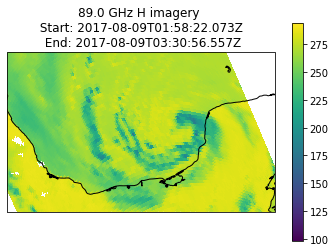

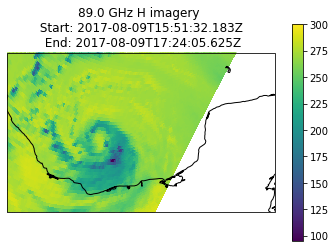

In [643]:
gmi_swath_match('AL072017', tcs_ri, channel=8)